In [1]:
# ============== 1. SETUP AND IMPORTS ==============
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# ============== 2. DATA LOADING ==============
# This section loads the image paths and labels from the directory structure.
images = []
labels = []
# Ensure this path matches the location of your dataset
data_path = './dataset'

# This loop might need adjustment if your directory structure is different
for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if os.path.isdir(subfolder_path):
        for folder in os.listdir(subfolder_path):
            subfolder_path2 = os.path.join(subfolder_path, folder)
            if os.path.isdir(subfolder_path2):
                for image_filename in os.listdir(subfolder_path2):
                    image_path = os.path.join(subfolder_path2, image_filename)
                    images.append(image_path)
                    labels.append(folder)

df = pd.DataFrame({'image': images, 'label': labels})
print(f"Loaded {len(df)} image paths.")
print(df['label'].value_counts())

Loaded 44000 image paths.
label
NonDemented         12800
VeryMildDemented    11200
ModerateDemented    10000
MildDemented        10000
Name: count, dtype: int64


In [3]:
# ============== 3. DATA SPLITTING ==============
# This creates the train, validation, and test sets.
# Using a fixed random_state ensures the split is the same every time.
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42, shuffle=True, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)

df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

print(f"\nTraining set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")


Training set size: 35200
Validation set size: 4400
Test set size: 4400


In [4]:
# ============== 4. MODEL TRAINING AND EVALUATION ==============

# Correct Data Preparation for Inception-ResNet-V2
# We MUST use the specific preprocess_input function for this model.
# It scales pixel values to the range [-1, 1].
inres_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True
)

image_size = (224, 224)
batch_size = 32

# Create the data generators using the correct settings
print("\nCreating data generators...")
train_generator_inres = inres_datagen.flow_from_dataframe(
    df_train, x_col='image', y_col='label',
    target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_generator_inres = inres_datagen.flow_from_dataframe(
    df_val, x_col='image', y_col='label',
    target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
test_generator_inres = inres_datagen.flow_from_dataframe(
    df_test, x_col='image', y_col='label',
    target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)


Creating data generators...
Found 35200 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.


In [5]:
# Build the Model
# Load the Inception-ResNet-V2 base model with pre-trained ImageNet weights
print("\nBuilding Inception-ResNet-V2 model...")
base_model_inres = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model_inres.trainable = False

# Add a robust custom classification head
x = base_model_inres.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions_inres = Dense(4, activation='softmax')(x)

model_inres = Model(inputs=base_model_inres.input, outputs=predictions_inres)

# Compile the Model with a Low Learning Rate
# This remains a critical step for stable transfer learning.
optimizer = Adam(learning_rate=0.0001)
model_inres.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model_inres.summary()


Building Inception-ResNet-V2 model...
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 55,131,876 (210.31 MB)

 Trainable params: 792,068 (3.02 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [6]:
# Train the Model
print("\nStarting model training...")
checkpoint_cb_inres = tf.keras.callbacks.ModelCheckpoint("model_InceptionResNetV2.keras", save_best_only=True)
early_stopping_cb_inres = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist_inres = model_inres.fit(
    train_generator_inres,
    epochs=20,
    validation_data=val_generator_inres,
    callbacks=[checkpoint_cb_inres, early_stopping_cb_inres]
)


Starting model training...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757201218.732984      79 service.cc:145] XLA service 0x7b074c002c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757201218.733047      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757201218.733051      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757201234.306669      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 235s 184ms/step - accuracy: 0.5297 - loss: 1.2095 - val_accuracy: 0.7223 - val_loss: 0.6307
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 202s 183ms/step - accuracy: 0.6811 - loss: 0.7486 - val_accuracy: 0.7752 - val_loss: 0.5305
Epoch 3/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 207s 188ms/step - accuracy: 0.7280 - loss: 0.6305 - val_accuracy: 0.7952 - val_loss: 0.4902
Epoch 4/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 207s 188ms/step - accuracy: 0.7558 - loss: 0.5703 - val_accuracy: 0.8143 - val_loss: 0.4551
Epoch 5/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 208s 188ms/step - accuracy: 0.7749 - loss: 0.5307 - val_accuracy: 0.8225 - val_loss: 0.4282
Epoch 6/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 208s 188ms/step - accuracy: 0.7917 - loss: 0.4959 - val_accuracy: 0.8395 - val_loss: 0.4108
Epoch 7/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 207s 188ms/step - accuracy: 0.8017 - loss: 0.4689 - val_accuracy: 0.8391 - val_loss: 0.3902
Epoch 8/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 207s 188ms/step - accuracy: 0.8

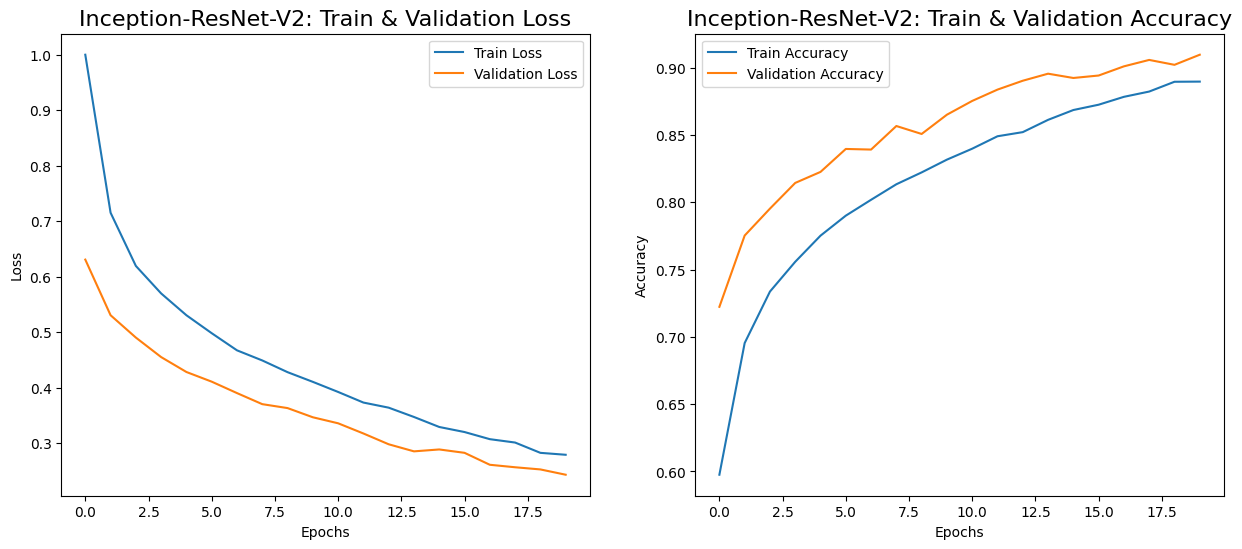

In [7]:
# Plot training and validation curves for Inception-ResNet-V2
hist_inres_df = pd.DataFrame(hist_inres.history)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_inres_df['loss'], label='Train Loss')
plt.plot(hist_inres_df['val_loss'], label='Validation Loss')
plt.title('Inception-ResNet-V2: Train & Validation Loss', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_inres_df['accuracy'], label='Train Accuracy')
plt.plot(hist_inres_df['val_accuracy'], label='Validation Accuracy')
plt.title('Inception-ResNet-V2: Train & Validation Accuracy', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


--- Inception-ResNet-V2 Test Set Evaluation ---
138/138 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.9161 - loss: 0.2410
Test Loss = 0.23497822880744934
Test Accuracy = 0.9127272963523865
138/138 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step

--- Inception-ResNet-V2 Classification Report ---
                  precision    recall  f1-score   support

    MildDemented       0.91      0.95      0.93      1000
ModerateDemented       1.00      1.00      1.00      1000
     NonDemented       0.89      0.87      0.88      1280
VeryMildDemented       0.86      0.85      0.85      1120

        accuracy                           0.91      4400
       macro avg       0.91      0.92      0.92      4400
    weighted avg       0.91      0.91      0.91      4400



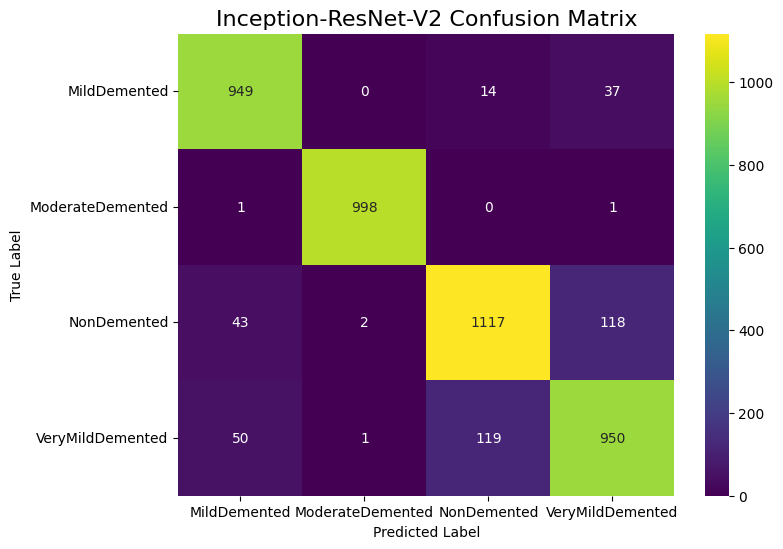

In [8]:
# Evaluate on the test set
print("\n--- Inception-ResNet-V2 Test Set Evaluation ---")
score_inres, acc_inres = model_inres.evaluate(test_generator_inres)
print('Test Loss =', score_inres)
print('Test Accuracy =', acc_inres)

# Generate predictions and classification report
predictions_inres = model_inres.predict(test_generator_inres)
y_pred_inres = np.argmax(predictions_inres, axis=1)
y_test_inres = test_generator_inres.classes

# Get the class names as a list of strings
class_names = list(test_generator_inres.class_indices.keys())

print("\n--- Inception-ResNet-V2 Classification Report ---")
print(classification_report(y_test_inres, y_pred_inres, target_names=class_names))

# Plot confusion matrix
cm_inres = confusion_matrix(y_test_inres, y_pred_inres)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_inres, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Inception-ResNet-V2 Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [9]:
# ============== 5. SAVE RESULTS ==============
# Save the training history to a CSV file
hist_df_inres = pd.DataFrame(hist_inres.history)
hist_df_inres.to_csv('history_inresv2.csv', index=False)

# Save the predictions to a numpy file
np.save('predictions_inresv2.npy', predictions_inres)

print("\nInception-ResNet-V2 results saved successfully!")


Inception-ResNet-V2 results saved successfully!
